In [22]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A Hierarchical Algorithm for Stop-Detection in Trajectory Data without Parameter Tuning

## Abstract

The study of human mobility has advanced greatly in recent years due to the availability of commercial large-scale GPS trajectory datasets. While there is a rich variety of applications leveraging these data, the validity of their findings depends heavily on the robustness of their processing algorithms to user-specified parameters. In particular, this is a problem for stop-detection algorithms on trajectories with high sparsity and noise—typical features in available datasets—wherein, for instance, roaming distance and time-gap tolerance parameters that work well for highly sparse users perform poorly on users with denser signals. With the aim of removing the critical obstacle of calibrating parameters to each trajectory, we investigate the types of errors in existing stop-detection algorithms and present a parameter-free algorithm extending the widely-used Density-Based Clustering Based on Hierarchical Density Estimates (HDBSCAN), to trajectory data. In the absence of ground-truth visitation data, we evaluate our algorithm on the synthetic Garden City sandbox environment, which simulates sparsity and noise in stylized random trajectories. We show that our algorithm outperforms baselines given by a widely-used sequential stop-detection algorithm (project Lachesis), and traditional DBSCAN.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx
import matplotlib.pyplot as plt
from pyproj import Transformer
import nomad.io.base as loader
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.city_gen as cg
import nomad.visit_attribution as va

In [2]:
traj_cols = {'user_id':'uid',
             'datetime':'local_datetime',
             'latitude':'latitude',
             'longitude':'longitude'}

# data = loader.from_file("../../nomad/data/gc_sample.csv")
data = loader.from_file("../../nomad/data/gc_3_stops.csv", timestamp='unix_timestamp', datetime='local_timestamp', user_id='identifier')

/Users/andresmondragon/nomad/nomad/io/base.py:614: UserWarning: The 'local_timestamp' column has timezone-naive records consider localizing or using unix timestamps.
  warnings.warn(f"The '{col}' column has timezone-naive records consider localizing or using unix timestamps.")


In [3]:
data.rename(columns={'unix_timestamp':'timestamp'}, inplace=True)

In [4]:
data

,x,y,local_timestamp,timestamp,identifier
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie
...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie


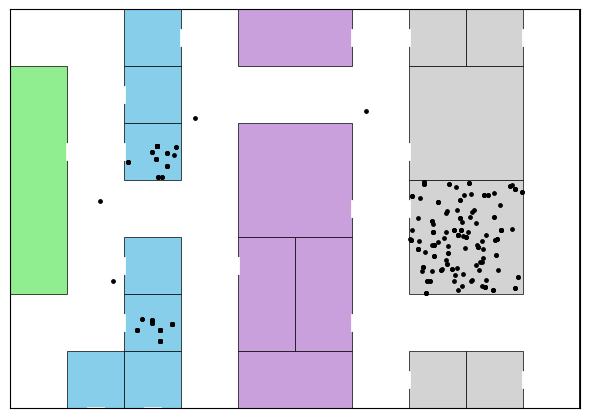

In [ ]:
%matplotlib inline

plot_df = data.copy()

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()
plt.show()

In [6]:
traj_cols = {'x':'x',
             'y':'y',
             'timestamp': 'timestamp'}

In [23]:
time_pairs, times = HDBSCAN._find_temp_neighbors(times = data['timestamp'], time_thresh = 60, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(data, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=5)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 10)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)

In [24]:
selected_clusters

{2, 3, 4}

In [25]:
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(traj = data,
                       traj_cols = traj_cols,
                       time_thresh = 60,
                       min_pts = 5,
                       min_cluster_size = 10)
sample_labels_hdbscan

time
1717200000    3
1717200060    3
1717200120    3
1717200180    3
1717200240    3
             ..
1717217760    2
1717217820    2
1717217880    2
1717217940    2
1717218000    2
Name: cluster, Length: 301, dtype: int64

In [26]:
sample_labels_hdbscan.unique()

array([ 3,  4, -1,  2])

In [27]:
data.merge(sample_labels_hdbscan, left_on='timestamp', right_index=True)

,x,y,local_timestamp,timestamp,identifier,cluster
0,14.500000,11.500000,2024-06-01 00:00:00,1717200000,Charlie,3
1,14.500000,11.500000,2024-06-01 00:01:00,1717200060,Charlie,3
2,14.500000,11.500000,2024-06-01 00:02:00,1717200120,Charlie,3
3,14.500000,11.500000,2024-06-01 00:03:00,1717200180,Charlie,3
4,14.672353,11.045084,2024-06-01 00:04:00,1717200240,Charlie,3
...,...,...,...,...,...,...
296,19.891026,10.332496,2024-06-01 04:56:00,1717217760,Charlie,2
297,19.891026,10.332496,2024-06-01 04:57:00,1717217820,Charlie,2
298,19.891026,10.332496,2024-06-01 04:58:00,1717217880,Charlie,2
299,19.692934,9.845237,2024-06-01 04:59:00,1717217940,Charlie,2


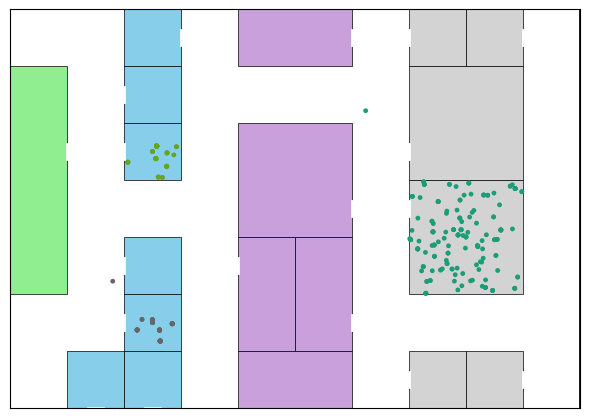

In [28]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = data.merge(sample_labels_hdbscan, left_on='timestamp', right_index=True)

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
del cluster_mapping[-1]
mapped_clusters = merged_data_hdbscan['cluster'].map(cluster_mapping).to_numpy()
cmap_base = plt.get_cmap('Dark2', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
# colors = ['gray'] + list(cmap_base.colors)
colors = list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(12, 22)
ax.set_ylim(7, 14)
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [19]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}
hdbscan_stop_table = HDBSCAN.st_hdbscan(traj = data,
                                        is_long_lat = False,
                                        is_datetime = False,
                                        traj_cols = traj_cols,
                                        complete_output = True,
                                        time_thresh = 60,
                                        min_pts = 5,
                                        min_cluster_size = 10)
hdbscan_stop_table

,start_timestamp,end_timestamp,x,y,diameter,n_pings,duration,max_gap
cluster,,,,,,,,
1,1717200000,1717207260,14.601203,11.051083,3.421362,122,121,1.0
2,1717207380,1717218000,19.861204,10.035797,4.068092,178,177,1.0


In [ ]:
hdbscan_stop_table.index

In [ ]:
va.point_in_polygon(traj=data,
                    labels=sample_labels_hdbscan,
                    stop_table=hdbscan_stop_table,
                    traj_cols=traj_cols,
                    is_datetime=False,
                    is_long_lat=False)

## Testing on new data

In [ ]:
sparse_df = loader.from_file("../../nomad/data/sparse_traj/", format="parquet", traj_cols=traj_cols,
                      parse_dates=True)
diaries_df = loader.from_file("../../nomad/data/diaries/", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)

### One Agent

In [ ]:
traj = sparse_df[sparse_df['uid'] == 'adoring_keldysh']
traj.loc[:,'local_timestamp'] = pd.to_datetime(traj['local_timestamp'])
diary = diaries_df[diaries_df['uid'] == 'adoring_keldysh']
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

In [ ]:
one_day_traj = traj[traj['date'] == '2024-01-01']
one_day_traj.head()

In [ ]:
%matplotlib inline

plot_df = traj.copy()
# plot_df = one_day_traj.copy()
plot_df.loc[:,'x'] = (plot_df['x'] - 4265699)/15
plot_df.loc[:,'y'] = (plot_df['y'] + 4392976)/15

fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Pings
ax.scatter(x=plot_df['x'], 
           y=plot_df['y'],
           s=6,
           color='black',
           alpha=1,
           zorder=2)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import warnings

def poi_map(traj, poi_table, traj_cols=None, max_distance=1, **kwargs):
    """
    Map pings in the trajectory to the POI table.

    Parameters
    ----------
    traj : pd.DataFrame
        The trajectory DataFrame containing x and y coordinates.
    poi_table : gpd.GeoDataFrame
        The POI table containing building geometries and IDs.
    traj_cols : list
        The columns in the trajectory DataFrame to be used for mapping.
    **kwargs : dict
        Additional keyword arguments.
    
    Returns
    -------
    pd.Series
        A Series containing the building IDs corresponding to the pings in the trajectory.
    """
    # Build pings GeoDataFrame
    pings_df = traj[['x', 'y']].copy()
    pings_df["pings_geometry"] = pings_df.apply(lambda row: Point(row["x"], row["y"]), axis=1)
    pings_df = gpd.GeoDataFrame(pings_df, geometry="pings_geometry", crs=poi_table.crs)
    
    # First spatial join (within)
    pings_df = gpd.sjoin(pings_df, poi_table, how="left", predicate="within")
    
    # Identify unmatched pings
    unmatched_mask = pings_df["building_id"].isna()
    unmatched_pings = pings_df[unmatched_mask].drop(columns=["building_id", "index_right"])
    
    if not unmatched_pings.empty:
        # Nearest spatial join for unmatched pings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*")
            nearest = gpd.sjoin_nearest(unmatched_pings, poi_table, how="left", max_distance=max_distance)

        # Keep only the first match for each original ping
        nearest = nearest.groupby(nearest.index).first()

        # Update original DataFrame with nearest matches
        pings_df.loc[unmatched_mask, "building_id"] = nearest["building_id"].values

    return pings_df["building_id"]

### One day

In [ ]:
plot_df = one_day_traj.copy()
plot_df.loc[:,'x'] = (plot_df['x'] - 4265699)/15
plot_df.loc[:,'y'] = (plot_df['y'] + 4392976)/15
gdf = gpd.read_file('../garden_city.geojson')
poi_labels = poi_map(plot_df,
                     poi_table=gdf)

In [ ]:
test_building_traj = one_day_traj.merge(poi_labels, left_index=True, right_index=True)
test_building_traj

In [ ]:
time_pairs, times = HDBSCAN._find_temp_neighbors(times = one_day_traj['timestamp'], time_thresh = 600, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(one_day_traj, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=2)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 3)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(label_history_df, selected_clusters)

In [ ]:
merged_data_hdbscan = test_building_traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan

In [ ]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = one_day_traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan.loc[:,'x'] = (merged_data_hdbscan['x'] - 4265699)/15
merged_data_hdbscan.loc[:,'y'] = (merged_data_hdbscan['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_hdbscan['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

### All days

In [ ]:
traj_cols = {'uid':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

time_pairs, times = HDBSCAN._find_temp_neighbors(times = traj['timestamp'], time_thresh = 600, is_datetime=False)
core_distances, coords = HDBSCAN._compute_core_distance(traj, time_pairs, times, is_long_lat=False, traj_cols=traj_cols, min_pts=2)
mrd = HDBSCAN._compute_mrd_graph(coords, times, time_pairs, core_distances, is_long_lat=False)
mst_edges = HDBSCAN._mst(mrd)
mstext_edges = HDBSCAN.mst_ext(mst_edges, core_distances)
label_history_df, hierarchy_df = HDBSCAN.hdbscan(mstext_edges, min_cluster_size = 3)
cluster_stability_df = HDBSCAN.compute_cluster_stability(label_history_df)
selected_clusters = HDBSCAN.select_most_stable_clusters(hierarchy_df, cluster_stability_df)
sample_labels_hdbscan = HDBSCAN.hdbscan_labels(label_history_df, selected_clusters)

In [ ]:
label_history_df

In [ ]:
sample_labels_hdbscan['cluster'].nunique()

In [ ]:
%matplotlib inline

# Merging sample data with labels
merged_data_hdbscan = traj.merge(sample_labels_hdbscan, left_on='timestamp', right_on='time')
merged_data_hdbscan.loc[:,'x'] = (merged_data_hdbscan['x'] - 4265699)/15
merged_data_hdbscan.loc[:,'y'] = (merged_data_hdbscan['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_hdbscan['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_hdbscan['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_hdbscan['x'], 
           merged_data_hdbscan['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

In [ ]:
hdbscan_stop_table = HDBSCAN.st_hdbscan(traj = traj,
                                        is_long_lat = False,
                                        is_datetime = False,
                                        traj_cols = traj_cols,
                                        complete_output = True,
                                        time_thresh = 600,
                                        min_pts = 2,
                                        min_cluster_size = 3)
hdbscan_stop_table

In [ ]:
lachesis_labels = LACHESIS._lachesis_labels(traj=traj,
                                            dur_min=5,
                                            dt_max=60,
                                            delta_roam=3,
                                            traj_cols=traj_cols)

lachesis_labels

In [ ]:
%matplotlib inline

# Merging sample data with labels
merged_data_lachesis = traj.merge(lachesis_labels.to_frame(name='cluster'), left_on='timestamp', right_index=True)
merged_data_lachesis.loc[:,'x'] = (merged_data_lachesis['x'] - 4265699)/15
merged_data_lachesis.loc[:,'y'] = (merged_data_lachesis['y'] + 4392976)/15
# merged_data_lachesis = merged_data_lachesis[~(merged_data_lachesis['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(merged_data_lachesis['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = merged_data_lachesis['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(merged_data_lachesis['x'], 
           merged_data_lachesis['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("Lachesis Stops for Sample User")
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

### HDBSCAN by date

In [ ]:
sample_labels_hdbscan_by_date = traj.groupby(['date']).apply(lambda x: HDBSCAN.st_hdbscan(traj = x,
                                                          is_long_lat = False,
                                                          is_datetime = False,
                                                          traj_cols = traj_cols,
                                                          complete_output = True,
                                                          time_thresh = 600,
                                                          min_pts = 2,
                                                          min_cluster_size = 3),
                            include_groups=False)
sample_labels_hdbscan_by_date

In [ ]:
sample_labels_hdbscan_by_date['cluster'].nunique()

In [ ]:
%matplotlib inline

# Merging sample data with labels
sample_labels_hdbscan_by_date.loc[:,'x'] = (sample_labels_hdbscan_by_date['x'] - 4265699)/15
sample_labels_hdbscan_by_date.loc[:,'y'] = (sample_labels_hdbscan_by_date['y'] + 4392976)/15
# merged_data_hdbscan = merged_data_hdbscan[~(merged_data_hdbscan['cluster'] == -1)]


fig, ax = plt.subplots(figsize=(6, 6))
plt.box(on=True)

# Plotting Garden City Map
city = cg.load('../garden-city.pkl')
city.plot_city(ax, doors=True, address=False)

# Getting colors for clusters
unique_clusters = sorted(sample_labels_hdbscan_by_date['cluster'].unique())
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
# del cluster_mapping[-1]
cmap_base = plt.get_cmap('tab10', len(unique_clusters) - (1 if -1 in unique_clusters else 0))
colors = ['black'] + list(cmap_base.colors)
extended_cmap = mcolors.ListedColormap(colors)
mapped_clusters = sample_labels_hdbscan_by_date['cluster'].map(lambda x: cluster_mapping[x] + 1 if x != -1 else 0).to_numpy()

extended_cmap = mcolors.ListedColormap(colors)

# Plotting Pings
ax.scatter(sample_labels_hdbscan_by_date['x'], 
           sample_labels_hdbscan_by_date['y'], 
           c=mapped_clusters, 
           cmap=extended_cmap, 
           s=6,
           alpha=1,
           zorder=2)

ax.set_yticklabels([])
ax.set_xticklabels([])
# ax.set_title("HDBSCAN Stops for Sample User")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

# plt.savefig('gc_empty.png')
plt.show()

## Simple test synthetic data

In [ ]:
# Synthetic dataset with connected 2 components connected by an edge with weight infinity
def synthetic_graph_with_cc():
    # MST edges within cluster A
    edges_a = [(1, 2, 0.15), (2, 3, 0.20)]
    # MST edges within cluster B
    edges_b = [(4, 5, 0.1), (5, 6, 0.19)]
    # Artificial high-weight edge between cluster A and B
    bridge_edge = [(3, 4, np.inf)]

    # Combine into full MST+ext
    mst_ext_df = pd.DataFrame(edges_a + edges_b + bridge_edge, columns=["from", "to", "weight"])

    return mst_ext_df

# Synthetic dataset with connected 4 components
def synthetic_graph_with_4cc():
    # Cluster A
    edges_a = [(1, 2, 5), (2, 3, 7)]
    # Cluster B
    edges_b = [(4, 5, 5), (5, 6, 8)]
    # Cluster C
    edges_c = [(7, 8, 2), (8, 9, 6)]
    # Cluster D
    edges_d = [(10, 11, 4), (11, 12, 8)]

    # Bridge edges with high weights
    bridges = [
        (3, 4, np.inf),  # A to B
        (6, 7, 20),  # B to C
        (9, 10, 15)  # C to D
    ]

    all_edges = edges_a + edges_b + edges_c + edges_d + bridges
    mst_ext_df = pd.DataFrame(all_edges, columns=["from", "to", "weight"])

    return mst_ext_df

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import imageio
import os

def visualize_mst_evolution(mst_df, gif_filename="mst_evolution.gif", duration=500.0):
    # Build full graph and collect all nodes
    full_edges = []
    all_nodes = set()

    for u, v, w in mst_df.itertuples(index=False):
        w_val = 1e6 if np.isinf(w) else w
        inv_w = 1.0 / w_val if w_val > 0 else 0.001
        label = "∞" if np.isinf(w) else f"{w:.2f}"
        full_edges.append((u, v, {'weight': w_val, 'inv_weight': inv_w, 'label': label}))
        all_nodes.update([u, v])

    # Sort edges by decreasing weight
    full_edges_sorted = sorted(full_edges, key=lambda x: -x[2]['weight'])

    # Fixed layout (use inverse weights)
    G_full = nx.Graph()
    G_full.add_nodes_from(all_nodes)
    G_full.add_edges_from(full_edges)
    pos = nx.spring_layout(G_full, weight='inv_weight', seed=50)

    # Iteratively remove edges and save frames
    frames = []
    for i in range(len(full_edges_sorted) + 1):
        G = nx.Graph()
        G.add_nodes_from(all_nodes)
        remaining_edges = full_edges_sorted[i:]
        G.add_edges_from(remaining_edges)

        edge_labels = nx.get_edge_attributes(G, 'label')

        # Draw and save
        plt.figure(figsize=(6, 6))
        nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=200, edge_color='gray', width=2)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, rotate=False,
                                     font_size=10, bbox=dict(facecolor='white', edgecolor='none'))
        plt.axis('off')

        # Add epsilon text (for removed edge weight)
        if i > 0:
            removed_edge = full_edges_sorted[i - 1]
            removed_weight = removed_edge[2]['weight']
            epsilon_display = "∞" if removed_weight >= 1e6 else f"{removed_weight:.2f}"
            plt.text(
                0.05, 0.95, f"ε = {epsilon_display}",
                transform=plt.gca().transAxes,
                fontsize=14, fontweight='bold',
                verticalalignment='top',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.5)
            )

        fname = f"mst_frame_{i:02d}.png"
        plt.savefig(fname)
        frames.append(fname)
        plt.close()

    # Create GIF
    with imageio.get_writer(gif_filename, mode="I", duration=duration, loop=0) as writer:
        for fname in frames:
            writer.append_data(imageio.imread(fname))

        # Add final frame pause
        final_img = imageio.imread(frames[-1])
        for _ in range(5):
            writer.append_data(final_img)

    for fname in frames:
        os.remove(fname)

In [ ]:
mst_4cc = synthetic_graph_with_4cc()
display(mst_4cc)
visualize_mst_evolution(mst_4cc)

In [ ]:
# mst_ext_df = synthetic_graph_with_cc()
# display(mst_ext_df)
# visualize_mst(mst_ext_df)

- λ_min(Ci): minimum density level at which Ci exists
    - ε_max(Ci): maximum ε value (scale) at which Ci exisits
- λ_max(xj,Ci): the density level beyond which object xj no longer belongs to cluster Ci
    - ε_min(xj , Ci): ε value (scale) beyond which object xj no longer belongs to cluster Ci

In [ ]:
# cluster_stability_df = pd.DataFrame({
#     "cluster_id": [2,3,4,5,6,7,8,9,10,11],
#     "cluster_stability": [7,5,6,6,2,1,1,1,2,2]
# })

# hierarchy_df = pd.DataFrame({
#     "child": [2,3,4,5,6,7,8,9,10,11],
#     "parent": [0,0,2,2,3,3,5,5,8,8],
#     "scale": [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]
# }) 